In [43]:
import pandas as pd 
from scipy.stats import chi2_contingency
from dython.nominal import associations
import tensorflow as tf

# Read processed data from csv files

df = pd.read_csv('../data/processed/sanitary_registry_medicines.csv')

df = df[['manufacturer', 'pharmaceutical_form', 'expiration_date', 'register_year']]

df['expiration_date'] = pd.to_datetime(df['expiration_date'])


df['durability'] =  df['expiration_date'].dt.year - df['register_year']

df = df.drop(columns=['expiration_date','register_year'])







Chi-square test for independence between manufacturer and pharmaceutical form
Chi-square:  260566.29208882272
p-value:  0.0
Degrees of freedom:  125622


c:\Users\Carlos Olivo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\Carlos Olivo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


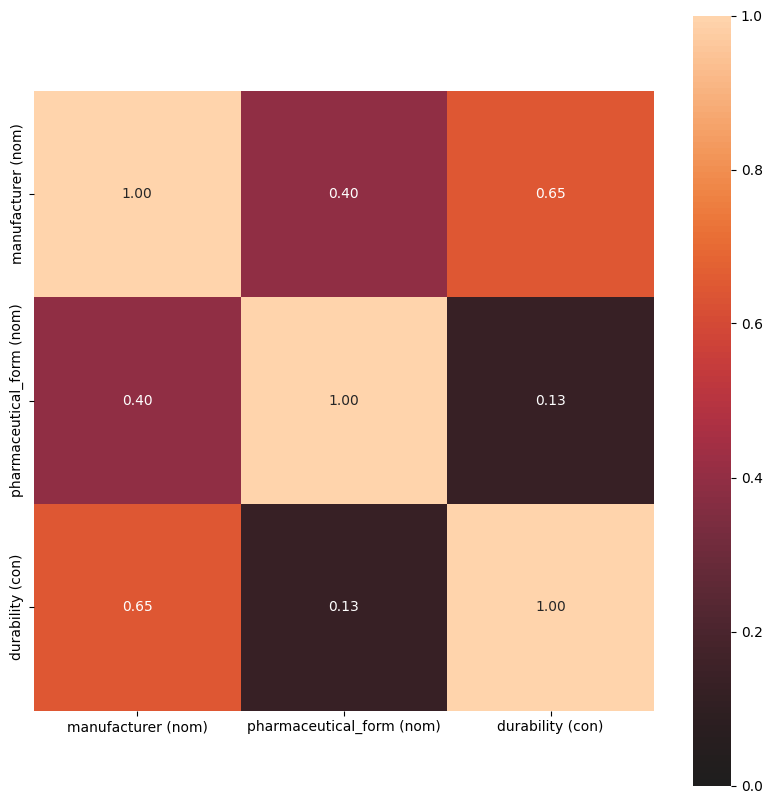

In [44]:
# Determine the relationship and correlation between variables using the Chi-square test for independence and the Cramer's V statistic


# Chi-square test for independence

# H0: There is no relationship between the variables

# H1: There is a relationship between the variables

# p-value < 0.05: reject H0

# p-value > 0.05: fail to reject H0

# p-value = 0.05: marginal

# Chi-square test for independence between manufacturer and pharmaceutical form

contingency_table = pd.crosstab(df['manufacturer'], df['pharmaceutical_form'])

chi2, p, dof, expected = chi2_contingency(contingency_table.values)

print('Chi-square test for independence between manufacturer and pharmaceutical form')

print('Chi-square: ', chi2)

print('p-value: ', p)

print('Degrees of freedom: ', dof)



# Correlations 

contingency_table = associations(df, nominal_columns=['manufacturer', 'pharmaceutical_form'], figsize=(10, 10), mark_columns=True, plot=True)

In [47]:
# Create dataset for the model to predict the expiration time of a medicine based on the manufacturer, pharmaceutical form


# One-hot encoding for categorical variables 

df_manufacturers = pd.get_dummies(df['manufacturer'])
df_forms = pd.get_dummies(df['pharmaceutical_form'])


# Normalize durability

df['durability'] = (df['durability'] - df['durability'].mean()) / df['durability'].std()

print(df.head())


# Create dataset for the model

dataset = pd.concat([df['durability'],df_manufacturers, df_forms], axis=1)

print(dataset.head())

# Split dataset into train and test sets

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


# Split features from labels

train_labels = train_dataset.pop('durability')
test_labels = test_dataset.pop('durability')







                                    manufacturer pharmaceutical_form  \
0           laboratorios de aplicaciones medicas          COMPRIMIDO   
1                       laboratorios ameripharma              JARABE   
2          sanofi-aventis de mexico s.a. de c.v.            SOLUCION   
3                             acromax dominicana             TABLETA   
4  gefarca industria  farmaceutica perezespinosa               CREMA   

   durability  
0    2.187690  
1    2.187690  
2    1.304238  
3    2.187690  
4    2.187690  
   durability  3m argentina s.a.c.i.f.i.a  3m health care limited  \
0    2.187690                       False                   False   
1    2.187690                       False                   False   
2    1.304238                       False                   False   
3    2.187690                       False                   False   
4    2.187690                       False                   False   

   9 vasanni centre 28  a. menarini manufacturing logist

In [112]:
# Build the model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation = 'relu' , input_shape=[len(train_dataset.keys())]),

       
    tf.keras.layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss='mse', optimizer=optimizer,metrics=['mae', 'mse'])

model.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 64)                131840    
                                                                 
 dense_60 (Dense)            (None, 1)                 65        
                                                                 
Total params: 131905 (515.25 KB)
Trainable params: 131905 (515.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
# Train the model

EPOCHS = 100

history = model.fit(
    train_dataset, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0)

# Evaluate the model

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Durability".format(mae))

# Make predictions

test_predictions = model.predict(test_dataset).flatten()

print(test_predictions)





86/86 - 0s - loss: 0.7122 - mae: 0.6399 - mse: 0.7122 - 153ms/epoch - 2ms/step
Testing set Mean Abs Error:  0.64 Durability
86/86 [==============================] - 0s 848us/step
[-0.07189053 -0.07189053  0.49709138 ... -0.22109908  0.54669136
  0.23624209]


0       -2.259581
13      -2.259581
21      -1.690599
25      -1.854086
26      -1.115273
           ...   
13674    1.160021
13675    2.595599
13685    1.125020
13688    1.892810
13704    1.582361
Name: durability, Length: 2741, dtype: float64


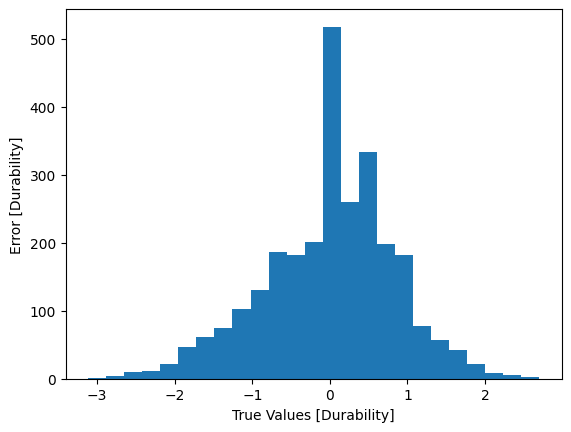

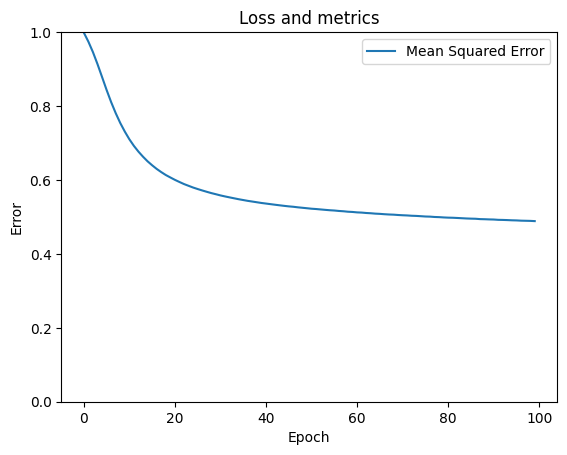

In [114]:
# Plot the predictions error distribution 

import matplotlib.pyplot as plt

error = test_predictions - test_labels
print(error)
plt.hist(error, bins = 25)
plt.xlabel('True Values [Durability]')
plt.ylabel('Error [Durability]')


plt.savefig('../model/error_distribution.png')
plt.show()




# Plot the loss and metrics


plt.plot(history.epoch, history.history['mse'], label='Mean Squared Error')





plt.title('Loss and metrics')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.ylim([0, 1])

plt.savefig('../model/loss_and_metrics.png')

plt.show()


In [117]:
# Save the model and labels for the one-hot encoding as json files
model.save('../model/medicine_durability_model.h5')


manufacturer_labels = df['manufacturer'].unique()
pharmaceutical_form_labels = df['pharmaceutical_form'].unique()

import json

with open('../model/manufacturer_labels.json', 'w') as outfile:
    json.dump(manufacturer_labels.tolist(), outfile)

with open('../model/pharmaceutical_form_labels.json', 'w') as outfile:
    json.dump(pharmaceutical_form_labels.tolist(), outfile)




c:\Users\Carlos Olivo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
